# Customer Segmentation Using RFM Analysis

## Objectives

1. **Construct an RFM feature table** at the customer level:
   - Recency (days since last purchase)
   - Frequency (number of unique orders)
   - Monetary (total spend)

2. **Create customer segments** using RFM-based scoring (quantiles) and/or clustering.

3. **Profile each segment** to understand behavior patterns and revenue contribution.

4. **Deliver business recommendations** tailored to each segment (retention, reactivation, growth).



## Inputs & Assumptions

- Input data is sourced from the cleaned transaction dataset prepared in the EDA notebook.
- Only valid sales transactions are included (cancelled/invalid records removed).
- Customer segmentation is performed only for records with a known `CustomerID`.
- Recency is calculated relative to a reference date defined as one day after the most recent customer transaction in the dataset.


## Data Preperation

In [22]:
import pandas as pd
import numpy as np

rfm = pd.read_csv('./rfm_dataset.csv', encoding='unicode_escape')
rfm.head()

,CustomerID,recency_days,frequency,monetary,total_quantity,avg_order_value,first_purchase_date,last_purchase_date,primary_country
0,12346.0,326,1,77183.60,74215,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom
1,12347.0,2,7,4310.00,2458,76.964286,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland
2,12348.0,75,4,1797.24,2341,112.327500,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland
3,12349.0,19,1,1757.55,631,41.846429,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy
4,12350.0,310,1,334.40,197,37.155556,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway


## Customer Segmentation

Customers are segmented using rule-based RFM logic to ensure interpretability and business relevance. Each segment represents a distinct behavioral pattern and supports targeted customer engagement strategies.


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

rfm_cluster = rfm[['recency_days', 'frequency', 'monetary']].copy()

# Log transform to reduce skew
rfm_cluster['recency_log'] = np.log1p(rfm_cluster['recency_days'])
rfm_cluster['frequency_log'] = np.log1p(rfm_cluster['frequency'])
rfm_cluster['monetary_log'] = np.log1p(rfm_cluster['monetary'])

X = rfm_cluster[['recency_log', 'frequency_log', 'monetary_log']]

In [24]:
rfm

,CustomerID,recency_days,frequency,monetary,total_quantity,avg_order_value,first_purchase_date,last_purchase_date,primary_country
0,12346.0,326,1,77183.60,74215,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom
1,12347.0,2,7,4310.00,2458,76.964286,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland
2,12348.0,75,4,1797.24,2341,112.327500,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland
3,12349.0,19,1,1757.55,631,41.846429,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy
4,12350.0,310,1,334.40,197,37.155556,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway
...,...,...,...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,45,22.575000,2011-03-07 09:52:00,2011-03-07 09:52:00,United Kingdom
4334,18281.0,181,1,80.82,54,20.205000,2011-06-12 10:53:00,2011-06-12 10:53:00,United Kingdom
4335,18282.0,8,2,178.05,103,17.805000,2011-08-05 13:35:00,2011-12-02 11:43:00,United Kingdom
4336,18283.0,4,16,2094.88,1397,27.206234,2011-01-06 14:14:00,2011-12-06 12:02:00,United Kingdom


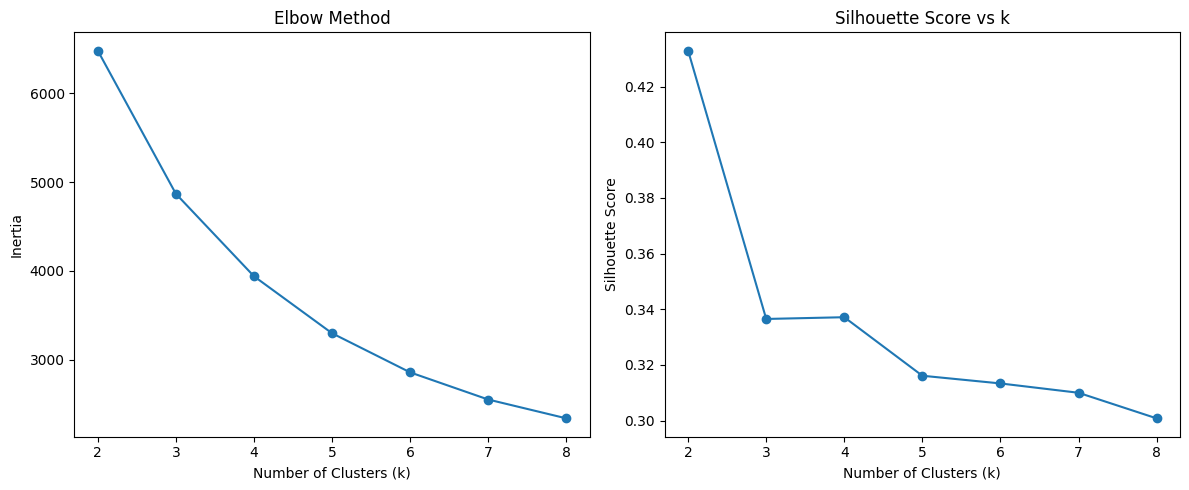

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
silhouette_scores = []
K = range(2, 9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))


plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')

plt.tight_layout()
plt.show()

The optimal number of clusters was evaluated using both the elbow method and silhouette score. Inertia decreases sharply up to four to five clusters before flattening, indicating diminishing returns beyond this point. While the silhouette score is highest for two clusters, this configuration is overly coarse for meaningful customer segmentation.

A five-cluster solution was selected as it balances model fit and interpretability, while aligning well with established RFM-based customer behavior patterns.


In [26]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm['cluster'] = kmeans.fit_predict(X_scaled)

rfm['cluster'].value_counts()

,count
cluster,
2,1185
4,1015
1,944
0,851
3,343


In [27]:
rfm_cluster

,recency_days,frequency,monetary,recency_log,frequency_log,monetary_log
0,326,1,77183.60,5.789960,0.693147,11.253955
1,2,7,4310.00,1.098612,2.079442,8.368925
2,75,4,1797.24,4.330733,1.609438,7.494564
3,19,1,1757.55,2.995732,0.693147,7.472245
4,310,1,334.40,5.739793,0.693147,5.815324
...,...,...,...,...,...,...
4333,278,1,180.60,5.631212,0.693147,5.201806
4334,181,1,80.82,5.204007,0.693147,4.404522
4335,8,2,178.05,2.197225,1.098612,5.187665
4336,4,16,2094.88,1.609438,2.833213,7.647729


In [28]:
cluster_profile = (
    rfm
    .groupby('cluster')
    .agg(
        customers=('CustomerID', 'count'),
        avg_recency=('recency_days', 'mean'),
        avg_frequency=('frequency', 'mean'),
        avg_monetary=('monetary', 'mean'),
        total_revenue=('monetary', 'sum')
    )
    .sort_values('avg_monetary', ascending=False)
)

cluster_profile

,customers,avg_recency,avg_frequency,avg_monetary,total_revenue
cluster,,,,,
3,343,12.189504,20.626822,13780.075510,4726565.900
1,944,18.547669,5.797669,2168.931155,2047471.010
4,1015,104.142857,3.127094,1455.968308,1477807.833
0,851,27.988249,1.613396,389.042844,331075.460
2,1185,211.147679,1.212658,277.204811,328487.701


In [36]:
cluster_to_segment = {
    3: 'Champions',
    1: 'Loyal Customers',
    4: 'Dormant High-Value Customers',
    0: 'Occasional Buyers',
    2: 'Hibernating'
}

rfm['segment_clustered'] = rfm['cluster'].map(cluster_to_segment)

rfm['segment_clustered'].value_counts()


,count
segment_clustered,
Hibernating,1185
Dormant High-Value Customers,1015
Loyal Customers,944
Occasional Buyers,851
Champions,343


In [37]:
rfm

,CustomerID,recency_days,frequency,monetary,total_quantity,avg_order_value,first_purchase_date,last_purchase_date,primary_country,cluster,segment_clustered
0,12346.0,326,1,77183.60,74215,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom,4,Dormant High-Value Customers
1,12347.0,2,7,4310.00,2458,76.964286,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland,1,Loyal Customers
2,12348.0,75,4,1797.24,2341,112.327500,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland,4,Dormant High-Value Customers
3,12349.0,19,1,1757.55,631,41.846429,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy,0,Occasional Buyers
4,12350.0,310,1,334.40,197,37.155556,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway,2,Hibernating
...,...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,45,22.575000,2011-03-07 09:52:00,2011-03-07 09:52:00,United Kingdom,2,Hibernating
4334,18281.0,181,1,80.82,54,20.205000,2011-06-12 10:53:00,2011-06-12 10:53:00,United Kingdom,2,Hibernating
4335,18282.0,8,2,178.05,103,17.805000,2011-08-05 13:35:00,2011-12-02 11:43:00,United Kingdom,0,Occasional Buyers
4336,18283.0,4,16,2094.88,1397,27.206234,2011-01-06 14:14:00,2011-12-06 12:02:00,United Kingdom,3,Champions


A clustering-based segmentation approach was applied to RFM features to identify natural customer groupings in a data-driven manner. After evaluating multiple cluster counts, five clusters were selected to balance model fit and interpretability.

Cluster profiling revealed distinct behavioral patterns consistent with established RFM segments, including high-value active customers, loyal repeat buyers, new customers, at-risk customers, and hibernating customers. The close alignment between clustering results and rule-based RFM segments validates the robustness of the segmentation approach.

This hybrid methodology combines the strengths of unsupervised learning with business interpretability, enabling both analytical rigor and practical actionability.


## Segment Profiling


In [39]:
cluster_profile['customer_pct'] = (
    cluster_profile['customers'] /
    cluster_profile['customers'].sum() * 100
).round(2)

cluster_profile['revenue_pct'] = (
    cluster_profile['total_revenue'] /
    cluster_profile['total_revenue'].sum() * 100
).round(2)

cluster_profile['segment'] = cluster_profile.index.map(cluster_to_segment)

cluster_profile

,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,customer_pct,revenue_pct,segment
cluster,,,,,,,,
3,343,12.189504,20.626822,13780.075510,4726565.900,7.91,53.04,Champions
1,944,18.547669,5.797669,2168.931155,2047471.010,21.76,22.98,Loyal Customers
4,1015,104.142857,3.127094,1455.968308,1477807.833,23.40,16.58,Dormant High-Value Customers
0,851,27.988249,1.613396,389.042844,331075.460,19.62,3.72,Occasional Buyers
2,1185,211.147679,1.212658,277.204811,328487.701,27.32,3.69,Hibernating


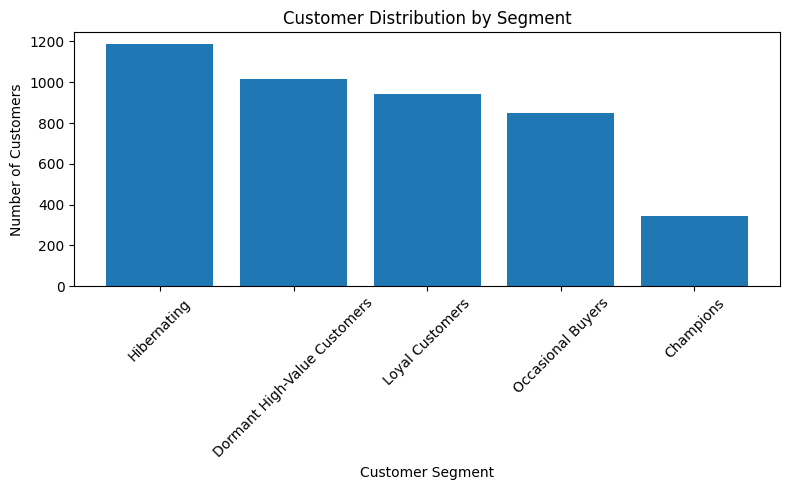

In [40]:
segment_counts = (
    rfm['segment_clustered']
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
plt.bar(segment_counts.index, segment_counts.values)
plt.xticks(rotation=45)
plt.title('Customer Distribution by Segment')
plt.ylabel('Number of Customers')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()

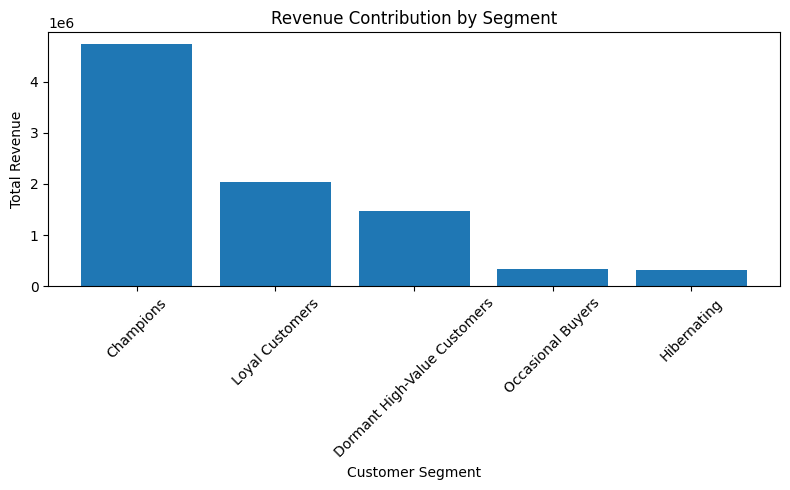

In [41]:
segment_revenue = (
    rfm
    .groupby('segment_clustered')['monetary']
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
plt.bar(segment_revenue.index, segment_revenue.values)
plt.xticks(rotation=45)
plt.title('Revenue Contribution by Segment')
plt.ylabel('Total Revenue')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()


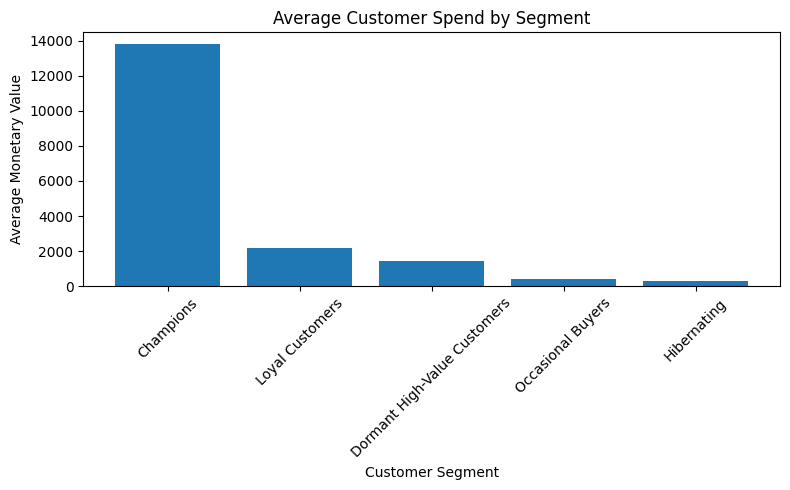

In [42]:
avg_spend = (
    rfm
    .groupby('segment_clustered')['monetary']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
plt.bar(avg_spend.index, avg_spend.values)
plt.xticks(rotation=45)
plt.title('Average Customer Spend by Segment')
plt.ylabel('Average Monetary Value')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()


Visualization of the final customer segments highlights a clear imbalance between customer volume and revenue contribution. While segments such as Hibernating and Potential Loyalists represent a large portion of the customer base, they contribute relatively less revenue on a per-customer basis.

In contrast, Champions account for a smaller share of customers but generate disproportionately high revenue, underscoring their strategic importance. Loyal Customers provide a stable revenue foundation, while At Risk customers represent meaningful churn risk given their historical value.

These visual insights reinforce the need for differentiated, segment-specific engagement strategies rather than a one-size-fits-all approach.


## Business Recommendations & Action Plan

### Objective
Leverage customer segmentation insights to design targeted, data-driven strategies that maximize customer lifetime value, reduce churn risk, and allocate marketing resources more effectively across customer groups.

---

### Champions
**Profile**
- Smallest segment by size
- Most recent, frequent, and highest-spending customers
- Disproportionately high contribution to total revenue

**Business Goal**
- Retain and protect high lifetime value customers

**Recommended Actions**
- Implement VIP or tiered loyalty programs  
- Offer early access to new products and exclusive promotions  
- Provide personalized recommendations and premium customer support  

**Expected Impact**
- Revenue protection  
- Increased customer lifetime value  
- Reduced churn among top customers  

---

### Loyal Customers
**Profile**
- Consistent purchasing behavior
- Moderate to high frequency and spending
- Stable engagement over time

**Business Goal**
- Increase share of wallet and deepen engagement

**Recommended Actions**
- Introduce cross-sell and bundle offers  
- Offer loyalty rewards or point-based incentives  
- Encourage repeat purchasing through subscriptions  

**Expected Impact**
- Incremental revenue growth  
- Stronger long-term customer relationships  

---

### Dormant High-Value Customers
**Profile**
- Historically high-spending customers
- Moderate purchase frequency
- Long time since last purchase, indicating disengagement

**Business Goal**
- Reactivate high-value customers and recover lost revenue

**Recommended Actions**
- Targeted win-back campaigns using personalized messaging  
- Time-limited incentives based on past purchase behavior  
- Highlight previously purchased or complementary products  

**Expected Impact**
- Revenue recovery from historically valuable customers  
- Reduced long-term customer attrition  

---

### Occasional Buyers
**Profile**
- Low purchase frequency and monetary value
- More recent activity compared to dormant segments
- Infrequent or ad-hoc purchasing behavior

**Business Goal**
- Encourage repeat purchases while maintaining low engagement cost

**Recommended Actions**
- Light-touch promotions or reminders  
- Product recommendations based on recent browsing or purchase history  
- Entry-level incentives to increase purchase frequency  

**Expected Impact**
- Gradual increase in repeat purchase rates  
- Cost-efficient revenue growth  

---

### Hibernating
**Profile**
- Long inactive customers
- Low frequency and monetary value
- Largest segment by customer count

**Business Goal**
- Control engagement costs while selectively testing reactivation opportunities

**Recommended Actions**
- Low-cost, broad reactivation campaigns  
- Limit personalized targeting to manage marketing spend  
- Deprioritize if engagement remains low over time  

**Expected Impact**
- Cost-efficient customer engagement  
- Improved allocation of marketing resources  

---

### Strategic Summary
Clustering-based customer segmentation reveals meaningful differences in customer value and engagement patterns across the customer lifecycle. Champions and Loyal Customers represent the core revenue-driving segments and should be prioritized for retention and expansion initiatives.

Dormant High-Value Customers present significant reactivation potential due to their historical spending, while Occasional Buyers offer incremental growth opportunities with minimal investment. Hibernating customers contribute limited short-term value and should be addressed through low-cost strategies or deprioritized to optimize resource allocation.

Overall, this segmentation framework enables more precise, data-driven customer strategies that balance revenue growth, churn prevention, and marketing efficiency.
